In [21]:
import numpy as np
import matplotlib.pyplot as plt

In [349]:
class BatchGD:
    def __init__(self, dim, lr, epochs, loss, loss_grad, lamb=0.4):
        self.dim = dim
        self.lr =  lr
        self.epochs = epochs
        self.weights = np.random.rand(dim)
        self.loss = loss
        self.loss_grad = loss_grad
        self.lamb = lamb


    def train(self, xs, ys, bs, q_precision=1e-5, weights_precision=1e-4):
        q = self.loss(self.weights, xs, ys).mean()
        losses = []
        for i in range(self.epochs):
            batch_idxs = np.random.choice(np.arange(len(xs)), size=bs, replace=False)
            batch_xs = xs[batch_idxs, :]
            batch_ys = ys[batch_idxs]

            eps = self.loss(self.weights, batch_xs, batch_ys).mean()
            losses.append(q)
            prev_weights = self.weights

            self.weights = self.weights - self.lr * self.loss_grad(self.weights, batch_xs, batch_ys).mean(axis=1)
            prev_q = q
            q = self.lamb * eps + (1 - self.lamb) * prev_q

            print(f'Epoch: {i + 1}. Loss: {q}')

            if np.abs(q - prev_q) < q_precision and np.abs(self.weights - prev_weights).mean() < weights_precision:
                return losses
        return losses

    def predict(self, xs):
        return xs @ self.weights

In [369]:
f = lambda x: -5 * x[:, 0] + 3 * x[:, 1]
loss = lambda weights, xs, ys: (xs @ weights - ys) ** 2
loss_grad = lambda weights, xs, ys: np.array([2 * (xs @ weights - ys) * (xs[:, i]) for i in range(len(weights))])

In [370]:
a, b = -10, 10
xs = (b - a) * np.random.random_sample((100, 1)) + a
xs =  np.append(xs, np.ones((100, 1)), axis=1)
ys = f(xs).flatten()

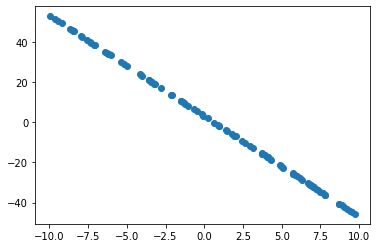

In [371]:
plt.scatter(xs[:, 0], ys)

### SGD

In [448]:
sgd_algo = BatchGD(2, 1e-2, 1000, loss, loss_grad)

In [449]:
sgd_losses = sgd_algo.train(xs, ys, 1)

Epoch: 1. Loss: 1370.1820700367812
Epoch: 2. Loss: 825.7038050565254
Epoch: 3. Loss: 919.9313438167931
Epoch: 4. Loss: 850.383961140381
Epoch: 5. Loss: 641.7007427426782
Epoch: 6. Loss: 1087.828797428681
Epoch: 7. Loss: 1199.9672322502652
Epoch: 8. Loss: 867.8021600417821
Epoch: 9. Loss: 667.4562613889761
Epoch: 10. Loss: 859.2148616769832
Epoch: 11. Loss: 590.783576674103
Epoch: 12. Loss: 636.9304645627021
Epoch: 13. Loss: 590.2474996683595
Epoch: 14. Loss: 386.8944061237607
Epoch: 15. Loss: 436.29034781097465
Epoch: 16. Loss: 432.27586701044163
Epoch: 17. Loss: 862.9828503137655
Epoch: 18. Loss: 634.7977568953263
Epoch: 19. Loss: 755.0351363720374
Epoch: 20. Loss: 826.9419009968508
Epoch: 21. Loss: 630.4547232907639
Epoch: 22. Loss: 472.64102080245556
Epoch: 23. Loss: 389.0255574203678
Epoch: 24. Loss: 254.64346478136733
Epoch: 25. Loss: 154.8594628660919
Epoch: 26. Loss: 193.09398440491867
Epoch: 27. Loss: 116.88580909249129
Epoch: 28. Loss: 86.88306335514405
Epoch: 29. Loss: 66.091

Text(0.5, 1.0, 'SGD Loss (Q)')

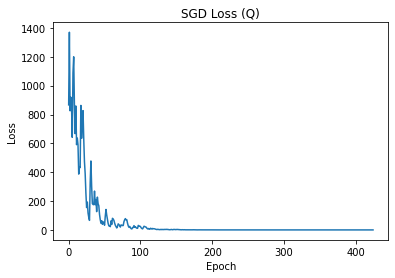

In [450]:
plt.plot(sgd_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD Loss (Q)')

In [451]:
preds = sgd_algo.predict(xs)

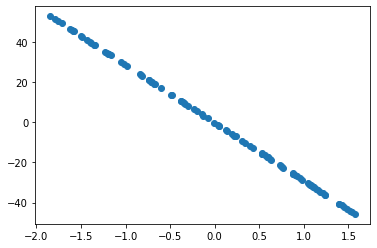

In [452]:
plt.scatter(xs[:, 0], preds)

### Minibatch (20)

In [454]:
minibatch_algo = BatchGD(2, 1e-2, 1000, loss, loss_grad)

In [455]:
minibatch_losses = minibatch_algo.train(xs, ys, bs=40)

Epoch: 1. Loss: 808.3300945090776
Epoch: 2. Loss: 755.5778484623829
Epoch: 3. Loss: 769.7410097258252
Epoch: 4. Loss: 750.1601355836015
Epoch: 5. Loss: 765.9242158704565
Epoch: 6. Loss: 794.8108137382808
Epoch: 7. Loss: 717.5345166043851
Epoch: 8. Loss: 710.9908911843952
Epoch: 9. Loss: 647.5257512153017
Epoch: 10. Loss: 597.4460744869473
Epoch: 11. Loss: 573.1778161020139
Epoch: 12. Loss: 548.6600731347154
Epoch: 13. Loss: 546.9099827972318
Epoch: 14. Loss: 527.5950442423562
Epoch: 15. Loss: 529.8849962463122
Epoch: 16. Loss: 472.4673466002414
Epoch: 17. Loss: 463.7018729454736
Epoch: 18. Loss: 414.03203243859286
Epoch: 19. Loss: 413.9183041546279
Epoch: 20. Loss: 375.7097551517626
Epoch: 21. Loss: 371.73828595405445
Epoch: 22. Loss: 347.97196442173174
Epoch: 23. Loss: 342.5671536993675
Epoch: 24. Loss: 324.9857783115333
Epoch: 25. Loss: 324.6318940964815
Epoch: 26. Loss: 316.43200474772516
Epoch: 27. Loss: 324.62604592081567
Epoch: 28. Loss: 298.004771845713
Epoch: 29. Loss: 296.3998

Text(0.5, 1.0, 'Minibatch Loss (Q)')

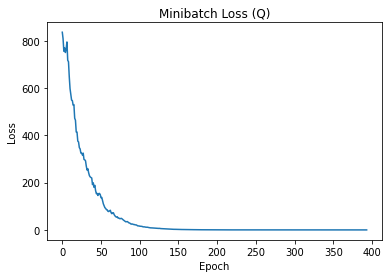

In [456]:
plt.plot(minibatch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Minibatch Loss (Q)')

In [457]:
preds = minibatch_algo.predict(xs)

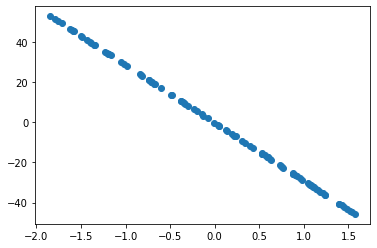

In [458]:
plt.scatter(xs[:, 0], preds)

### Batch (full dataset)

In [461]:
batch_algo = BatchGD(2, 1e-2, 1000, loss, loss_grad, 1.0)

In [462]:
batch_losses = batch_algo.train(xs, ys, bs=100)

Epoch: 1. Loss: 845.2669348778534
Epoch: 2. Loss: 811.7943642566906
Epoch: 3. Loss: 779.6473074321253
Epoch: 4. Loss: 748.7732740578134
Epoch: 5. Loss: 719.121852405124
Epoch: 6. Loss: 690.6446270498809
Epoch: 7. Loss: 663.2950998187058
Epoch: 8. Loss: 637.0286138658851
Epoch: 9. Loss: 611.8022807567959
Epoch: 10. Loss: 587.5749104388268
Epoch: 11. Loss: 564.3069439854494
Epoch: 12. Loss: 541.9603890036254
Epoch: 13. Loss: 520.498757599082
Epoch: 14. Loss: 499.88700679815827
Epoch: 15. Loss: 480.09148132895126
Epoch: 16. Loss: 461.07985866832473
Epoch: 17. Loss: 442.8210962650591
Epoch: 18. Loss: 425.2853808529627
Epoch: 19. Loss: 408.44407977118544
Epoch: 20. Loss: 392.26969421224646
Epoch: 21. Loss: 376.7358143214415
Epoch: 22. Loss: 361.8170760743124
Epoch: 23. Loss: 347.48911986176967
Epoch: 24. Loss: 333.72855071524356
Epoch: 25. Loss: 320.51290010692
Epoch: 26. Loss: 307.82058926268587
Epoch: 27. Loss: 295.6308939278835
Epoch: 28. Loss: 283.9239105283394
Epoch: 29. Loss: 272.6805

Text(0.5, 1.0, 'Minibatch Loss (Q)')

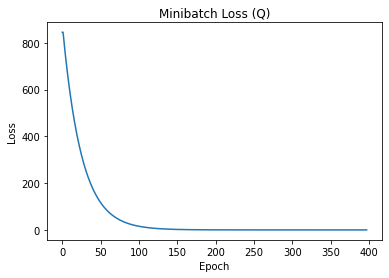

In [463]:
plt.plot(batch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Minibatch Loss (Q)')

In [464]:
preds = batch_algo.predict(xs)

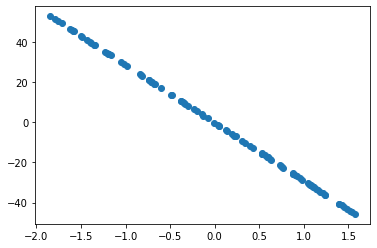

In [465]:
plt.scatter(xs[:, 0], preds)

In [466]:
scaled = xs
scaled[:, 0] = (scaled[:, 0] - scaled[:, 0].mean(axis=0)) / scaled[:, 0].std(axis=0)
ys_scaled = f(scaled).flatten()

In [467]:
sgd_algo_scaled = BatchGD(2, 1e-2, 1000, loss, loss_grad)
sgd_losses_scaled = sgd_algo_scaled.train(scaled, ys_scaled, 1)

Epoch: 1. Loss: 24.672858396552876
Epoch: 2. Loss: 19.137328476891145
Epoch: 3. Loss: 14.172427591098556
Epoch: 4. Loss: 28.285135224537555
Epoch: 5. Loss: 21.87204748284878
Epoch: 6. Loss: 13.182188593691732
Epoch: 7. Loss: 7.9562138370534905
Epoch: 8. Loss: 45.96679395147061
Epoch: 9. Loss: 27.65841721442133
Epoch: 10. Loss: 16.954931028076142
Epoch: 11. Loss: 28.5448915966112
Epoch: 12. Loss: 22.084747366468903
Epoch: 13. Loss: 13.689077963975308
Epoch: 14. Loss: 19.00778781902461
Epoch: 15. Loss: 11.420481080866189
Epoch: 16. Loss: 60.251848379928305
Epoch: 17. Loss: 39.344796723788356
Epoch: 18. Loss: 30.836851909119595
Epoch: 19. Loss: 20.658828312059434
Epoch: 20. Loss: 15.857059200533033
Epoch: 21. Loss: 11.555727914036218
Epoch: 22. Loss: 28.987828465259014
Epoch: 23. Loss: 27.895967309764544
Epoch: 24. Loss: 16.76010547370699
Epoch: 25. Loss: 24.283643869690266
Epoch: 26. Loss: 15.080207446515889
Epoch: 27. Loss: 14.765710108082551
Epoch: 28. Loss: 12.357262894084151
Epoch: 2

Text(0.5, 1.0, 'SGD Loss (Scaled) (Q)')

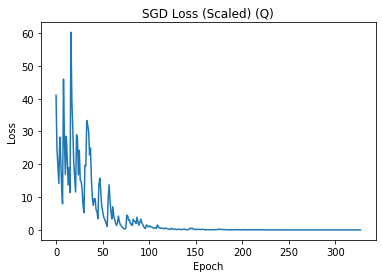

In [468]:
plt.plot(sgd_losses_scaled)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD Loss (Scaled) (Q)')